In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r"C:\Users\ASUS\OneDrive\Desktop\EXEMPTED\CODED\ML\T1\traffic flow\traffic.csv")
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values('DateTime')

In [16]:
# arranging data junction wise
df_pivot = df.pivot(index='DateTime', columns='Junction', values='Vehicles')
df_pivot = df_pivot.fillna(0)
lst
print(df_pivot.head())
print(df_pivot.shape)
# Filter Junction 1
df_j1 = df[df['Junction']==1][['DateTime','Vehicles']].copy()

Junction                1    2    3    4
DateTime                                
2015-11-01 00:00:00  15.0  6.0  9.0  0.0
2015-11-01 01:00:00  13.0  6.0  7.0  0.0
2015-11-01 02:00:00  10.0  5.0  5.0  0.0
2015-11-01 03:00:00   7.0  6.0  1.0  0.0
2015-11-01 04:00:00   9.0  7.0  2.0  0.0
(14592, 4)


In [17]:
df_j1['hour'] = df_j1['DateTime'].dt.hour
df_j1['dayofweek'] = df_j1['DateTime'].dt.dayofweek
df_j1.drop('DateTime', axis=1, inplace=True)

print(df_j1.head())


   Vehicles  hour  dayofweek
0        15     0          6
1        13     1          6
2        10     2          6
3         7     3          6
4         9     4          6


In [18]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_j1)


In [19]:
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, 24)

print(X.shape)  # (samples, 24, 3)
print(y.shape)  # (samples, 3)


(14568, 24, 3)
(14568, 3)


In [20]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [21]:
# lstm for junc 1

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model_j1_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

model_j1_lstm.compile(optimizer='adam', loss='mse')
model_j1_lstm.fit(X_train, y_train[:,0], epochs=15, batch_size=32)


Epoch 1/15


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


365/365 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0046
Epoch 2/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0018
Epoch 3/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0016
Epoch 4/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0014
Epoch 5/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0013
Epoch 6/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0011    
Epoch 7/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0011    
Epoch 8/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0010    
Epoch 9/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 9.6312e-04
Epoch 10/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 9.1833e-04
Epoch 11/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 8.9108e-04
Epoch 12/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 8.5134e-04
Epoch 13/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 8.4995e-04
Epoch 14/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 8.3976e-04
Epoch 15/15
365/36

In [22]:
pred = model_j1_lstm.predict(X_test)


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step   


In [23]:
pred_real = scaler.inverse_transform(
    np.hstack([pred, np.zeros((len(pred), 2))])
)[:,0]

y_test_real = scaler.inverse_transform(y_test)[:,0]


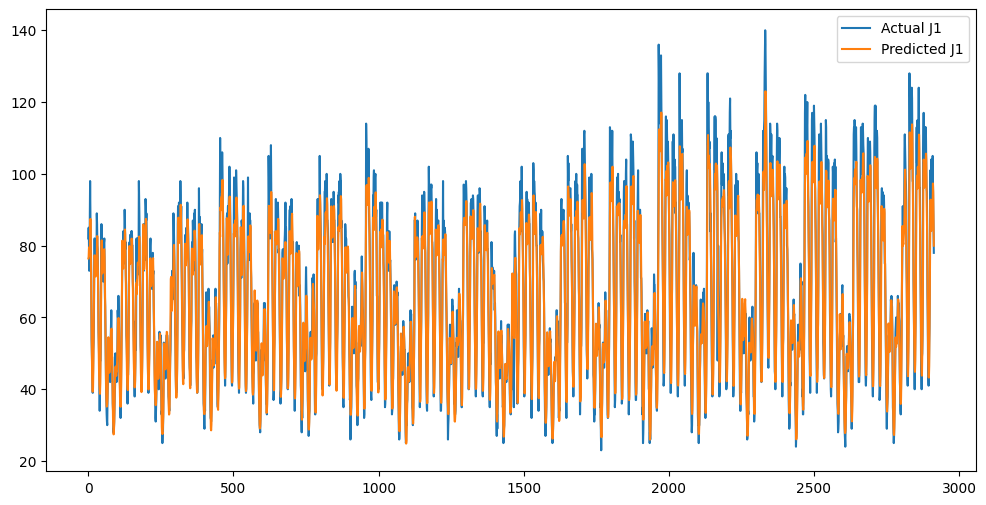

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test_real, label="Actual J1")
plt.plot(pred_real, label="Predicted J1")
plt.legend()
plt.show()


In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


In [26]:
y_true = y_test_real.ravel()
y_pred = pred_real.ravel()


In [27]:
# errors of lstm junction 1

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print("J1 LSTM MAE :", mae)
print("J1 LSTM RMSE:", rmse)
print("J1 LSTM MSE :", mse)


J1 LSTM MAE : 4.418063597189866
J1 LSTM RMSE: 6.167115727177966
J1 LSTM MSE : 38.03331639240581


In [28]:
# gru model of junction 1

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

model_j1_gru = Sequential([
    GRU(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    GRU(32),
    Dense(1)
])

model_j1_gru.compile(optimizer='adam', loss='mse')
model_j1_gru.fit(X_train, y_train[:,0], epochs=15, batch_size=32)


Epoch 1/15


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


365/365 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0044
Epoch 2/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0017
Epoch 3/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0014
Epoch 4/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0012
Epoch 5/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0011    
Epoch 6/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0010    
Epoch 7/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0010    
Epoch 8/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 9.2315e-04
Epoch 9/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 8.8442e-04
Epoch 10/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 8.8022e-04
Epoch 11/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 9.0455e-04
Epoch 12/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 8.7115e-04
Epoch 13/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 8.3122e-04
Epoch 14/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 8.1460e-04
Epoch 15/15
36

In [29]:
pred_gru = model_j1_gru.predict(X_test)

pred_gru_real = scaler.inverse_transform(
    np.hstack([pred_gru, np.zeros((len(pred_gru), 2))])
)[:,0]


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step   


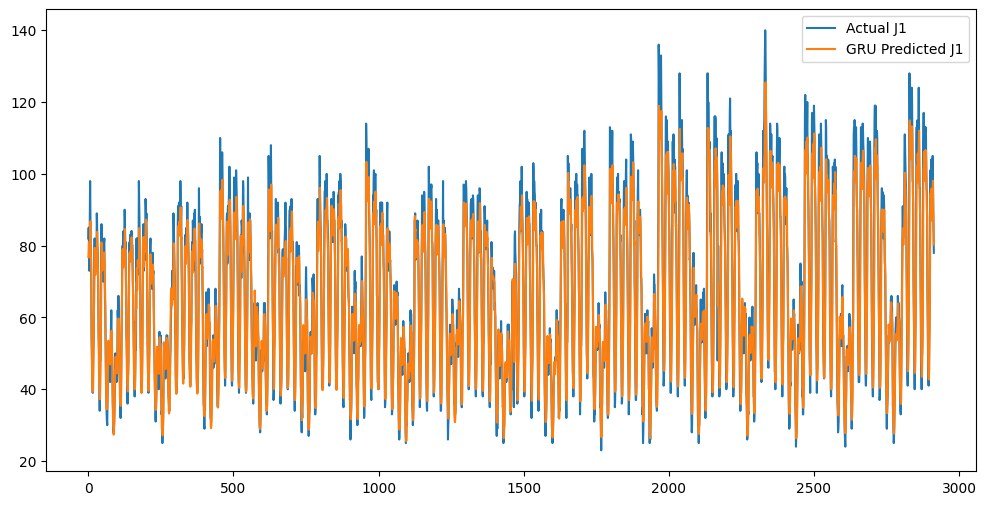

In [30]:
plt.figure(figsize=(12,6))
plt.plot(y_test_real, label="Actual J1")
plt.plot(pred_gru_real, label="GRU Predicted J1")
plt.legend()
plt.show()


In [31]:
# errors of gru for junction 1

y_true = y_test_real.ravel()
y_pred = pred_gru_real.ravel()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print("J1 GRU MAE :", mae)
print("J1 GRU RMSE:", rmse)
print("J1 GRU MSE :", mse)


J1 GRU MAE : 4.283211931115811
J1 GRU RMSE: 5.969467591333194
J1 GRU MSE : 35.634543323977326


In [33]:
# tranformer for junction 1

from tensorflow.keras.layers import Input, MultiHeadAttention, LayerNormalization, Dense, GlobalAveragePooling1D, Dropout, Add
from tensorflow.keras.models import Model

inputs = Input(shape=(X.shape[1], X.shape[2]))  # (24, 3)

# Attention block
attn = MultiHeadAttention(num_heads=4, key_dim=16)(inputs, inputs)
attn = Dropout(0.1)(attn)
attn = Add()([inputs, attn])
attn = LayerNormalization(epsilon=1e-6)(attn)

# Feed-forward block
ff = Dense(64, activation='relu')(attn)
ff = Dense(X.shape[2])(ff)  # IMPORTANT FIX
ff = Dropout(0.1)(ff)
ff = Add()([attn, ff])
ff = LayerNormalization(epsilon=1e-6)(ff)

# Output
pooled = GlobalAveragePooling1D()(ff)
outputs = Dense(1)(pooled)

model_j1_tr = Model(inputs, outputs)
model_j1_tr.compile(optimizer='adam', loss='mse')
model_j1_tr.fit(X_train, y_train[:,0], epochs=20, batch_size=32)



Epoch 1/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0171
Epoch 2/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0088
Epoch 3/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0084
Epoch 4/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0078
Epoch 5/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0072
Epoch 6/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0073
Epoch 7/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0068
Epoch 8/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0065
Epoch 9/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0067
Epoch 10/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0063
Epoch 11/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0062
Epoch 12/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0060
Epoch 13/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0058
Epoch 14/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0051
Epoch 15/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - lo

In [34]:
pred_tr = model_j1_tr.predict(X_test)

pred_tr_real = scaler.inverse_transform(
    np.hstack([pred_tr, np.zeros((len(pred_tr), 2))])
)[:,0]


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step   


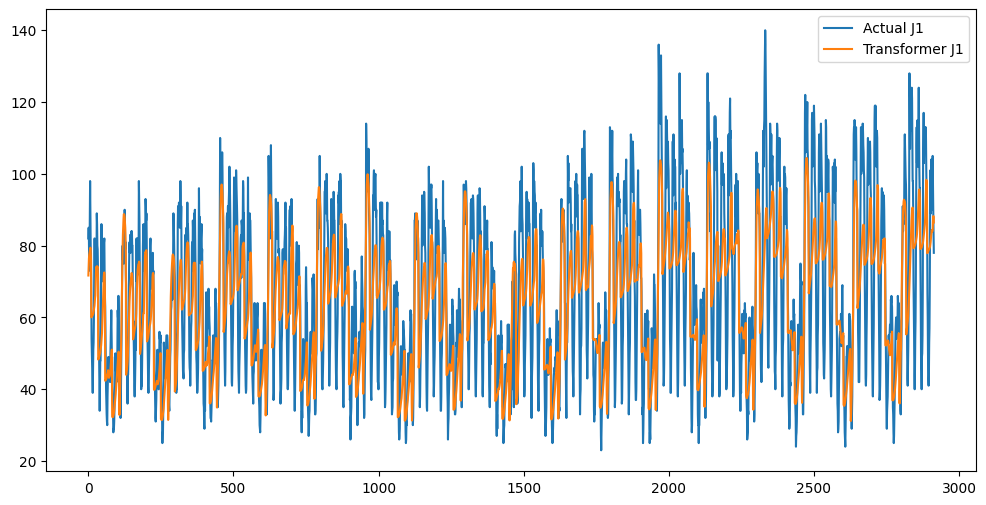

In [35]:
plt.figure(figsize=(12,6))
plt.plot(y_test_real, label="Actual J1")
plt.plot(pred_tr_real, label="Transformer J1")
plt.legend()
plt.show()


In [36]:
y_true = y_test_real.ravel()
y_pred = pred_tr_real.ravel()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print("J1 Transformer MAE :", mae)
print("J1 Transformer RMSE:", rmse)
print("J1 Transformer MSE :", mse)


J1 Transformer MAE : 11.9839677411191
J1 Transformer RMSE: 15.064289491612126
J1 Transformer MSE : 226.93281788709552


In [37]:
df_j2 = df[df['Junction']==2][['DateTime','Vehicles']].copy()


In [38]:
df_j2['hour'] = df_j2['DateTime'].dt.hour
df_j2['dayofweek'] = df_j2['DateTime'].dt.dayofweek
df_j2.drop('DateTime', axis=1, inplace=True)

print(df_j2.head())


       Vehicles  hour  dayofweek
14592         6     0          6
14593         6     1          6
14594         5     2          6
14595         6     3          6
14596         7     4          6


In [39]:
scaler_j2 = MinMaxScaler()
scaled_j2 = scaler_j2.fit_transform(df_j2)


In [40]:
X2, y2 = create_sequences(scaled_j2, 24)

print(X2.shape)
print(y2.shape)


(14568, 24, 3)
(14568, 3)


In [41]:
split = int(0.8 * len(X2))
X2_train, X2_test = X2[:split], X2[split:]
y2_train, y2_test = y2[:split], y2[split:]


In [42]:
# lstm for junc 2

model_j2_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X2.shape[1], X2.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

model_j2_lstm.compile(optimizer='adam', loss='mse')
model_j2_lstm.fit(X2_train, y2_train[:,0], epochs=15, batch_size=32)


Epoch 1/15


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


365/365 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0037
Epoch 2/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0026
Epoch 3/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0025
Epoch 4/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0024
Epoch 5/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0023
Epoch 6/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0023
Epoch 7/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0023
Epoch 8/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0023
Epoch 9/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0023
Epoch 10/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0023
Epoch 11/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0022
Epoch 12/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0023
Epoch 13/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0022
Epoch 14/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0022
Epoch 15/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step 

In [43]:
pred_j2 = model_j2_lstm.predict(X2_test)

pred_j2_real = scaler_j2.inverse_transform(
    np.hstack([pred_j2, np.zeros((len(pred_j2), 2))])
)[:,0]

y2_test_real = scaler_j2.inverse_transform(y2_test)[:,0]


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step   


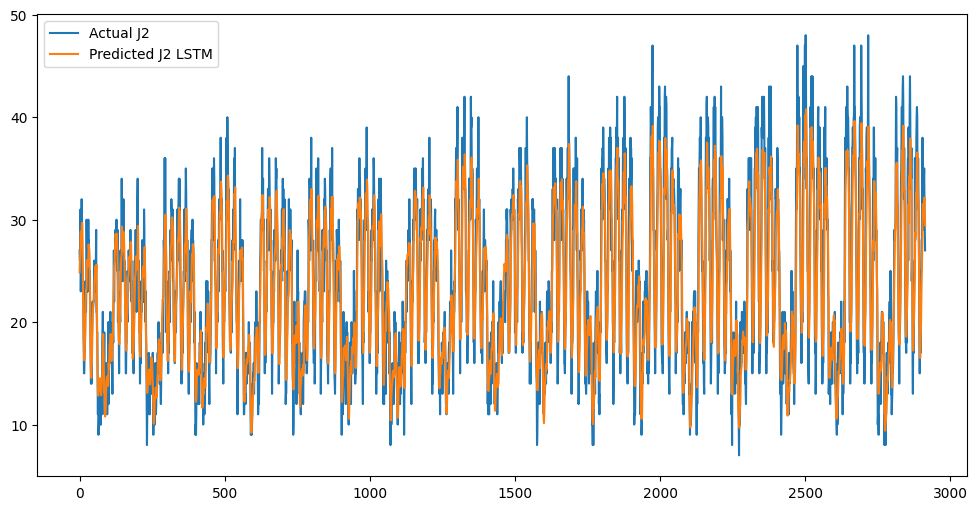

In [44]:
plt.figure(figsize=(12,6))
plt.plot(y2_test_real, label="Actual J2")
plt.plot(pred_j2_real, label="Predicted J2 LSTM")
plt.legend()
plt.show()


In [45]:
y_true = y2_test_real.ravel()
y_pred = pred_j2_real.ravel()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print("J2 LSTM MAE :", mae)
print("J2 LSTM RMSE:", rmse)
print("J2 LSTM MSE :", mse)


J2 LSTM MAE : 2.5064580679788686
J2 LSTM RMSE: 3.2562553471922806
J2 LSTM MSE : 10.60319888611832


In [46]:
from tensorflow.keras.layers import GRU

model_j2_gru = Sequential([
    GRU(64, return_sequences=True, input_shape=(X2.shape[1], X2.shape[2])),
    Dropout(0.2),
    GRU(32),
    Dense(1)
])

model_j2_gru.compile(optimizer='adam', loss='mse')
model_j2_gru.fit(X2_train, y2_train[:,0], epochs=15, batch_size=32)


Epoch 1/15


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


365/365 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0043
Epoch 2/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0027
Epoch 3/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0025
Epoch 4/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0025
Epoch 5/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0024
Epoch 6/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0024
Epoch 7/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0024
Epoch 8/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0023
Epoch 9/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0023
Epoch 10/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0023
Epoch 11/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0023
Epoch 12/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0022
Epoch 13/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0023
Epoch 14/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0023
Epoch 15/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step 

In [47]:
pred_j2_gru = model_j2_gru.predict(X2_test)

pred_j2_gru_real = scaler_j2.inverse_transform(
    np.hstack([pred_j2_gru, np.zeros((len(pred_j2_gru), 2))])
)[:,0]


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step   


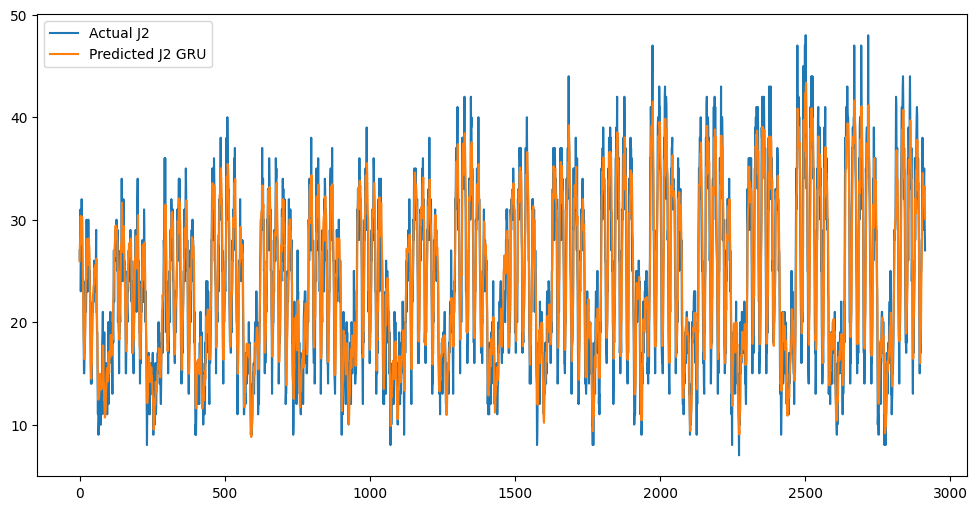

In [48]:
plt.figure(figsize=(12,6))
plt.plot(y2_test_real, label="Actual J2")
plt.plot(pred_j2_gru_real, label="Predicted J2 GRU")
plt.legend()
plt.show()


In [49]:
y_true = y2_test_real.ravel()
y_pred = pred_j2_gru_real.ravel()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print("J2 GRU MAE :", mae)
print("J2 GRU RMSE:", rmse)
print("J2 GRU MSE :", mse)


J2 GRU MAE : 2.4761288096705116
J2 GRU RMSE: 3.104225456674934
J2 GRU MSE : 9.6362156858687


In [50]:
# transformer of junc 2

from tensorflow.keras.layers import Input, MultiHeadAttention, LayerNormalization, Dense, GlobalAveragePooling1D, Dropout, Add
from tensorflow.keras.models import Model

inputs = Input(shape=(X2.shape[1], X2.shape[2]))  # (24, 3)

# Attention block
attn = MultiHeadAttention(num_heads=4, key_dim=16)(inputs, inputs)
attn = Dropout(0.1)(attn)
attn = Add()([inputs, attn])
attn = LayerNormalization(epsilon=1e-6)(attn)

# Feed-forward block (dimension must return to 3)
ff = Dense(64, activation='relu')(attn)
ff = Dense(X2.shape[2])(ff)
ff = Dropout(0.1)(ff)
ff = Add()([attn, ff])
ff = LayerNormalization(epsilon=1e-6)(ff)

# Output
pooled = GlobalAveragePooling1D()(ff)
outputs = Dense(1)(pooled)

model_j2_tr = Model(inputs, outputs)
model_j2_tr.compile(optimizer='adam', loss='mse')

model_j2_tr.fit(X2_train, y2_train[:,0], epochs=20, batch_size=32)


Epoch 1/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0450
Epoch 2/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0094
Epoch 3/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0075
Epoch 4/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0068
Epoch 5/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0063
Epoch 6/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0061
Epoch 7/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0060
Epoch 8/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0060
Epoch 9/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0061
Epoch 10/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0064
Epoch 11/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0070
Epoch 12/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0064
Epoch 13/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0059
Epoch 14/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0055
Epoch 15/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - lo

In [51]:
pred_j2_tr = model_j2_tr.predict(X2_test)

pred_j2_tr_real = scaler_j2.inverse_transform(
    np.hstack([pred_j2_tr, np.zeros((len(pred_j2_tr), 2))])
)[:,0]


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step   


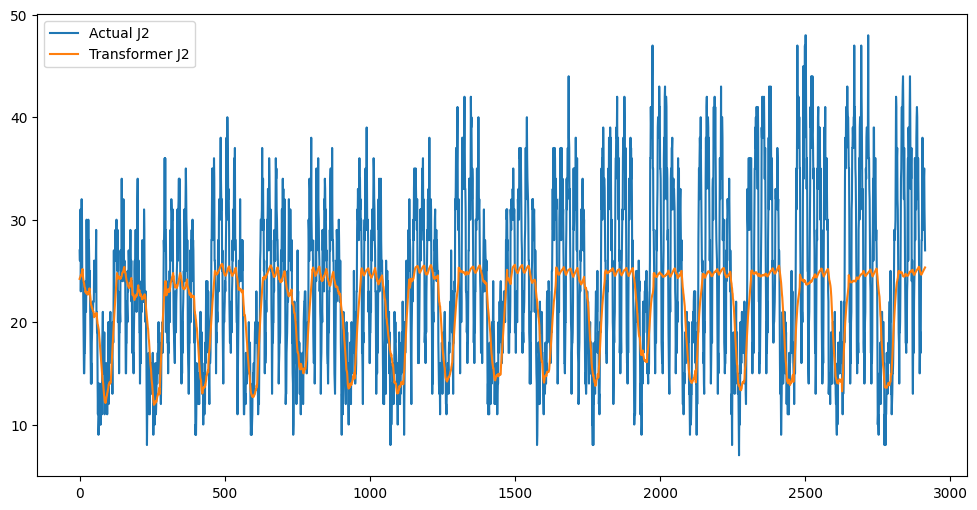

In [52]:
plt.figure(figsize=(12,6))
plt.plot(y2_test_real, label="Actual J2")
plt.plot(pred_j2_tr_real, label="Transformer J2")
plt.legend()
plt.show()


In [53]:
y_true = y2_test_real.ravel()
y_pred = pred_j2_tr_real.ravel()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print("J2 Transformer MAE :", mae)
print("J2 Transformer RMSE:", rmse)
print("J2 Transformer MSE :", mse)


J2 Transformer MAE : 5.73560009188004
J2 Transformer RMSE: 7.169104303331287
J2 Transformer MSE : 51.396056512043174


In [54]:
df_j3 = df[df['Junction']==3][['DateTime','Vehicles']].copy()

In [55]:
df_j3['hour'] = df_j3['DateTime'].dt.hour
df_j3['dayofweek'] = df_j3['DateTime'].dt.dayofweek
df_j3.drop('DateTime', axis=1, inplace=True)


In [56]:
scaler_j3 = MinMaxScaler()
scaled_j3 = scaler_j3.fit_transform(df_j3)


In [57]:
X3, y3 = create_sequences(scaled_j3, 24)
print(X3.shape, y3.shape)


(14568, 24, 3) (14568, 3)


In [58]:
split = int(0.8 * len(X3))
X3_train, X3_test = X3[:split], X3[split:]
y3_train, y3_test = y3[:split], y3[split:]


In [59]:
# lstm for junc 3

model_j3_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X3.shape[1], X3.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

model_j3_lstm.compile(optimizer='adam', loss='mse')
model_j3_lstm.fit(X3_train, y3_train[:,0], epochs=15, batch_size=32)


Epoch 1/15


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


365/365 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0019
Epoch 2/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0014
Epoch 3/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0011
Epoch 4/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 9.9862e-04
Epoch 5/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 9.0723e-04
Epoch 6/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 8.6643e-04
Epoch 7/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 8.8709e-04
Epoch 8/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 8.6763e-04
Epoch 9/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 8.4822e-04
Epoch 10/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 8.4174e-04
Epoch 11/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 8.2417e-04
Epoch 12/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 8.3192e-04
Epoch 13/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 8.0760e-04
Epoch 14/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 8.0969e-04
Epoch 15/1

In [60]:
pred_j3 = model_j3_lstm.predict(X3_test)

pred_j3_real = scaler_j3.inverse_transform(
    np.hstack([pred_j3, np.zeros((len(pred_j3), 2))])
)[:,0]

y3_test_real = scaler_j3.inverse_transform(y3_test)[:,0]


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step   


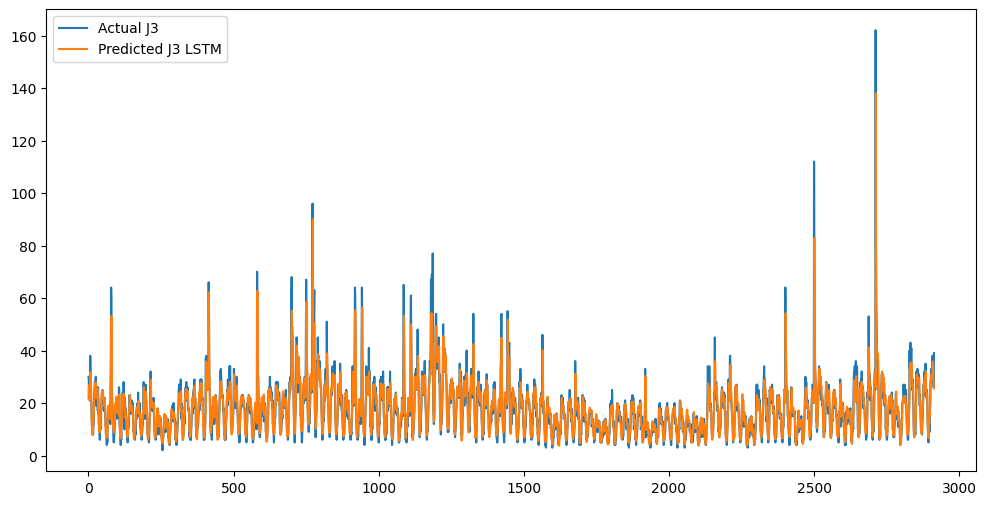

In [61]:
plt.figure(figsize=(12,6))
plt.plot(y3_test_real, label="Actual J3")
plt.plot(pred_j3_real, label="Predicted J3 LSTM")
plt.legend()
plt.show()


In [62]:
y_true = y3_test_real.ravel()
y_pred = pred_j3_real.ravel()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print("J3 LSTM MAE :", mae)
print("J3 LSTM RMSE:", rmse)
print("J3 LSTM MSE :", mse)


J3 LSTM MAE : 3.0036159020582662
J3 LSTM RMSE: 5.583647091157696
J3 LSTM MSE : 31.177114838593795


In [63]:
# gru for junction 3

model_j3_gru = Sequential([
    GRU(64, return_sequences=True, input_shape=(X3.shape[1], X3.shape[2])),
    Dropout(0.2),
    GRU(32),
    Dense(1)
])

model_j3_gru.compile(optimizer='adam', loss='mse')
model_j3_gru.fit(X3_train, y3_train[:,0], epochs=15, batch_size=32)


Epoch 1/15


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


365/365 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0020
Epoch 2/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0012
Epoch 3/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 9.5996e-04
Epoch 4/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 9.2395e-04
Epoch 5/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 9.0380e-04
Epoch 6/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 8.9025e-04
Epoch 7/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 8.9188e-04
Epoch 8/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 8.7075e-04
Epoch 9/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 8.4969e-04
Epoch 10/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 8.2254e-04
Epoch 11/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 8.0516e-04
Epoch 12/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 8.3062e-04
Epoch 13/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 8.2366e-04
Epoch 14/15
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 8.1583e-04
Epoch 

In [64]:
pred_j3_gru = model_j3_gru.predict(X3_test)

pred_j3_gru_real = scaler_j3.inverse_transform(
    np.hstack([pred_j3_gru, np.zeros((len(pred_j3_gru), 2))])
)[:,0]


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step   


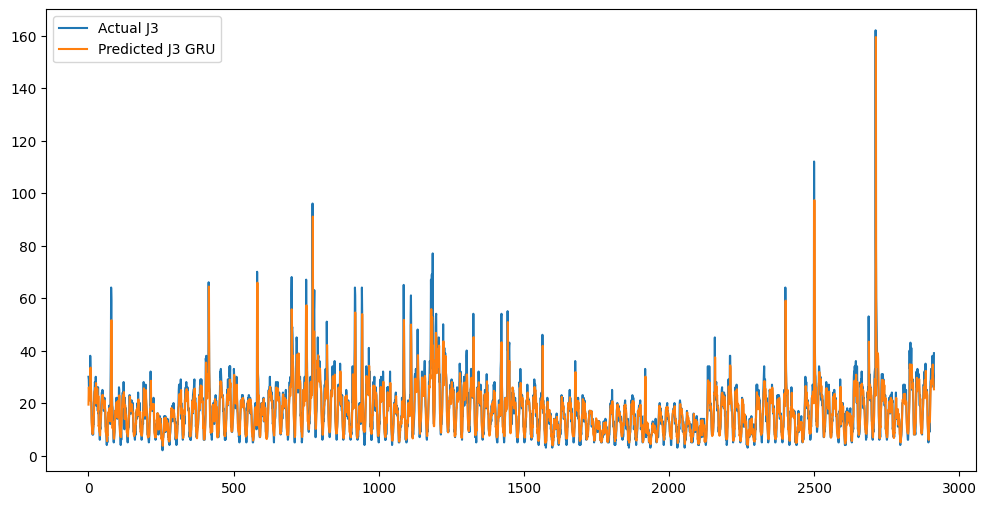

In [65]:
plt.figure(figsize=(12,6))
plt.plot(y3_test_real, label="Actual J3")
plt.plot(pred_j3_gru_real, label="Predicted J3 GRU")
plt.legend()
plt.show()


In [66]:
y_true = y3_test_real.ravel()
y_pred = pred_j3_gru_real.ravel()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print("J3 GRU MAE :", mae)
print("J3 GRU RMSE:", rmse)
print("J3 GRU MSE :", mse)


J3 GRU MAE : 3.0295690793873886
J3 GRU RMSE: 5.824254238829654
J3 GRU MSE : 33.921937438525184


In [69]:
# transformer for junc 3

inputs = Input(shape=(X3.shape[1], X3.shape[2]))  # (24, 3)

# Attention block
attn = MultiHeadAttention(num_heads=4, key_dim=16)(inputs, inputs)
attn = Dropout(0.1)(attn)
attn = Add()([inputs, attn])
attn = LayerNormalization(epsilon=1e-6)(attn)

# Feed-forward block
ff = Dense(64, activation='relu')(attn)
ff = Dense(X3.shape[2])(ff)
ff = Dropout(0.1)(ff)
ff = Add()([attn, ff])
ff = LayerNormalization(epsilon=1e-6)(ff)

# Output
pooled = GlobalAveragePooling1D()(ff)
outputs = Dense(1)(pooled)

model_j3_tr = Model(inputs, outputs)
model_j3_tr.compile(optimizer='adam', loss='mse')

model_j3_tr.fit(X3_train, y3_train[:,0], epochs=20, batch_size=32)


Epoch 1/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0500
Epoch 2/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0095
Epoch 3/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0078
Epoch 4/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0063
Epoch 5/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0053
Epoch 6/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0044
Epoch 7/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0037
Epoch 8/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0034
Epoch 9/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0031
Epoch 10/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0029
Epoch 11/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0026
Epoch 12/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0025
Epoch 13/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0023
Epoch 14/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0023
Epoch 15/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - lo

In [70]:
pred_j3_tr = model_j3_tr.predict(X3_test)

pred_j3_tr_real = scaler_j3.inverse_transform(
    np.hstack([pred_j3_tr, np.zeros((len(pred_j3_tr), 2))])
)[:,0]


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 


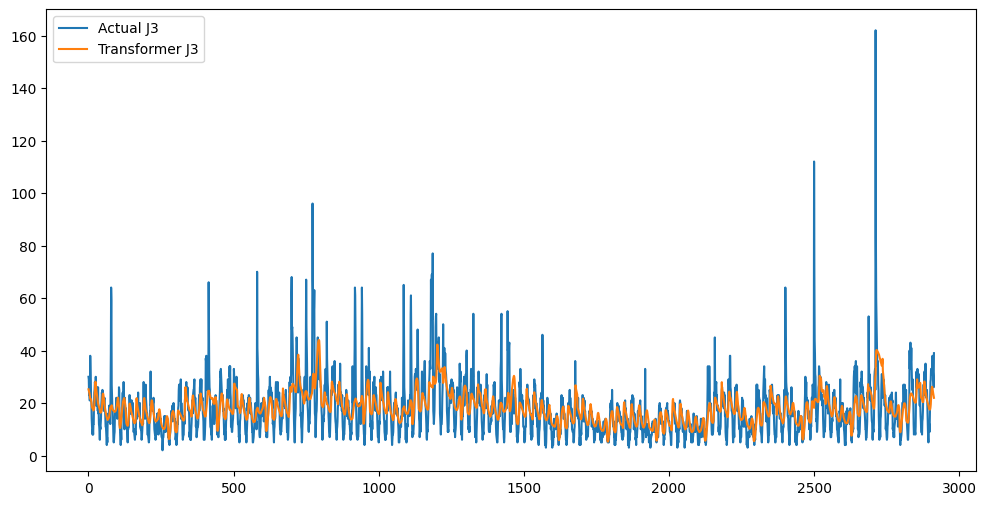

In [71]:
plt.figure(figsize=(12,6))
plt.plot(y3_test_real, label="Actual J3")
plt.plot(pred_j3_tr_real, label="Transformer J3")
plt.legend()
plt.show()


In [72]:
y_true = y3_test_real.ravel()
y_pred = pred_j3_tr_real.ravel()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print("J3 Transformer MAE :", mae)
print("J3 Transformer RMSE:", rmse)
print("J3 Transformer MSE :", mse)


J3 Transformer MAE : 5.274713305172216
J3 Transformer RMSE: 8.288481649554251
J3 Transformer MSE : 68.69892805499757


In [73]:
df_j4 = df[df['Junction']==4][['DateTime','Vehicles']].copy()


In [74]:
df_j4['hour'] = df_j4['DateTime'].dt.hour
df_j4['dayofweek'] = df_j4['DateTime'].dt.dayofweek
df_j4.drop('DateTime', axis=1, inplace=True)


In [75]:
scaler_j4 = MinMaxScaler()
scaled_j4 = scaler_j4.fit_transform(df_j4)


In [76]:
X4, y4 = create_sequences(scaled_j4, 24)
print(X4.shape, y4.shape)


(4320, 24, 3) (4320, 3)


In [77]:
split = int(0.8 * len(X4))
X4_train, X4_test = X4[:split], X4[split:]
y4_train, y4_test = y4[:split], y4[split:]


In [78]:
# lstm for junc 4

model_j4_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X4.shape[1], X4.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

model_j4_lstm.compile(optimizer='adam', loss='mse')
model_j4_lstm.fit(X4_train, y4_train[:,0], epochs=15, batch_size=32)


Epoch 1/15


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0087
Epoch 2/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0056 
Epoch 3/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0050 
Epoch 4/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0049
Epoch 5/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0048 
Epoch 6/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0051 
Epoch 7/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0047 
Epoch 8/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0047 
Epoch 9/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0047
Epoch 10/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0046 
Epoch 11/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0046 
Epoch 12/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0046 
Epoch 13/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0046 
Epoch 14/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0046 
Epoch 15/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step -

In [79]:
pred_j4 = model_j4_lstm.predict(X4_test)

pred_j4_real = scaler_j4.inverse_transform(
    np.hstack([pred_j4, np.zeros((len(pred_j4), 2))])
)[:,0]

y4_test_real = scaler_j4.inverse_transform(y4_test)[:,0]


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


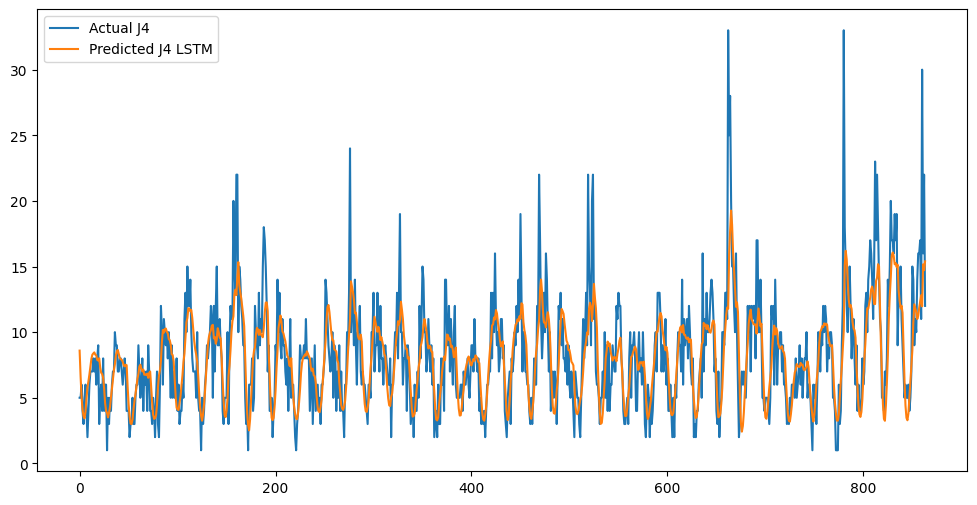

In [80]:
plt.figure(figsize=(12,6))
plt.plot(y4_test_real, label="Actual J4")
plt.plot(pred_j4_real, label="Predicted J4 LSTM")
plt.legend()
plt.show()


In [81]:
y_true = y4_test_real.ravel()
y_pred = pred_j4_real.ravel()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print("J4 LSTM MAE :", mae)
print("J4 LSTM RMSE:", rmse)
print("J4 LSTM MSE :", mse)


J4 LSTM MAE : 2.031786988730784
J4 LSTM RMSE: 2.8766494083391962
J4 LSTM MSE : 8.275111818498248


In [82]:
# gru for junc 4

model_j4_gru = Sequential([
    GRU(64, return_sequences=True, input_shape=(X4.shape[1], X4.shape[2])),
    Dropout(0.2),
    GRU(32),
    Dense(1)
])

model_j4_gru.compile(optimizer='adam', loss='mse')
model_j4_gru.fit(X4_train, y4_train[:,0], epochs=15, batch_size=32)


Epoch 1/15


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0080 
Epoch 2/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0054
Epoch 3/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0050 
Epoch 4/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0049
Epoch 5/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0048
Epoch 6/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0049
Epoch 7/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0046
Epoch 8/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0046
Epoch 9/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0046
Epoch 10/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0046 
Epoch 11/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0046
Epoch 12/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0045 
Epoch 13/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0044
Epoch 14/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0044
Epoch 15/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step 

In [83]:
pred_j4_gru = model_j4_gru.predict(X4_test)

pred_j4_gru_real = scaler_j4.inverse_transform(
    np.hstack([pred_j4_gru, np.zeros((len(pred_j4_gru), 2))])
)[:,0]


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


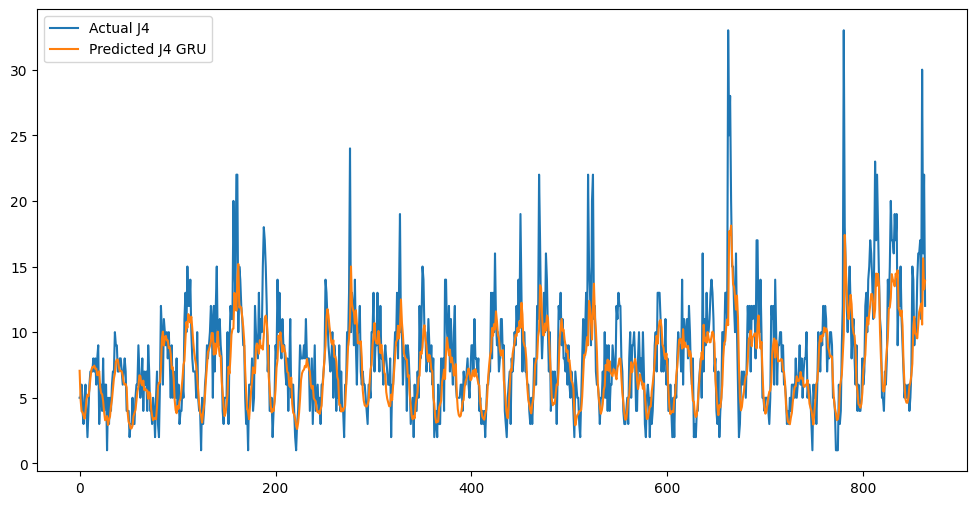

In [84]:
plt.figure(figsize=(12,6))
plt.plot(y4_test_real, label="Actual J4")
plt.plot(pred_j4_gru_real, label="Predicted J4 GRU")
plt.legend()
plt.show()


In [85]:
y_true = y4_test_real.ravel()
y_pred = pred_j4_gru_real.ravel()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print("J4 GRU MAE :", mae)
print("J4 GRU RMSE:", rmse)
print("J4 GRU MSE :", mse)


J4 GRU MAE : 2.0319894500576927
J4 GRU RMSE: 2.956122499667363
J4 GRU MSE : 8.738660233039619


In [86]:
# transformer for junc 4

inputs = Input(shape=(X4.shape[1], X4.shape[2]))  # (24, 3)

# Attention block
attn = MultiHeadAttention(num_heads=4, key_dim=16)(inputs, inputs)
attn = Dropout(0.1)(attn)
attn = Add()([inputs, attn])
attn = LayerNormalization(epsilon=1e-6)(attn)

# Feed-forward block
ff = Dense(64, activation='relu')(attn)
ff = Dense(X4.shape[2])(ff)  # must return to original feature size
ff = Dropout(0.1)(ff)
ff = Add()([attn, ff])
ff = LayerNormalization(epsilon=1e-6)(ff)

# Output
pooled = GlobalAveragePooling1D()(ff)
outputs = Dense(1)(pooled)

model_j4_tr = Model(inputs, outputs)
model_j4_tr.compile(optimizer='adam', loss='mse')

model_j4_tr.fit(X4_train, y4_train[:,0], epochs=20, batch_size=32)


Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 0.0380
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0091
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0088
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0087
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0086
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0085
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0085
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0084
Epoch 9/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0083
Epoch 10/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0083
Epoch 11/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0082
Epoch 12/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0082
Epoch 13/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0081
Epoch 14/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0079
Epoch 15/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 4

In [87]:
pred_j4_tr = model_j4_tr.predict(X4_test)

pred_j4_tr_real = scaler_j4.inverse_transform(
    np.hstack([pred_j4_tr, np.zeros((len(pred_j4_tr), 2))])
)[:,0]


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


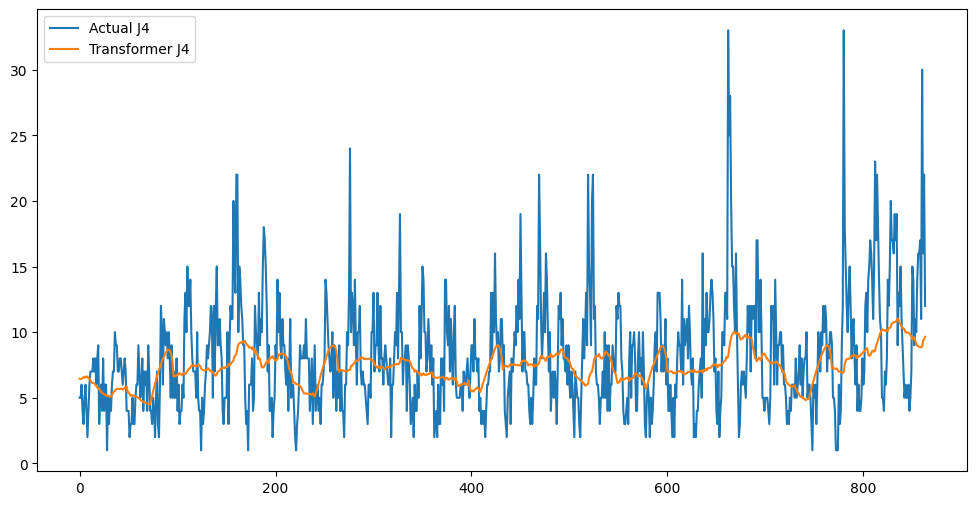

In [88]:
plt.figure(figsize=(12,6))
plt.plot(y4_test_real, label="Actual J4")
plt.plot(pred_j4_tr_real, label="Transformer J4")
plt.legend()
plt.show()


In [89]:
y_true = y4_test_real.ravel()
y_pred = pred_j4_tr_real.ravel()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print("J4 Transformer MAE :", mae)
print("J4 Transformer RMSE:", rmse)
print("J4 Transformer MSE :", mse)


J4 Transformer MAE : 2.9689694306364767
J4 Transformer RMSE: 4.077884713948529
J4 Transformer MSE : 16.629143740255078


In [ ]:
# cnn + lstm

In [90]:
df_pivot = df.pivot(index='DateTime', columns='Junction', values='Vehicles')
df_pivot = df_pivot.fillna(0)


In [91]:
scaler_spatial = MinMaxScaler()
scaled_spatial = scaler_spatial.fit_transform(df_pivot)


In [92]:
def create_sequences_multi(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

X_spatial, y_spatial = create_sequences_multi(scaled_spatial, 24)

print(X_spatial.shape)  # (samples, 24, 4)
print(y_spatial.shape)  # (samples, 4)


(14568, 24, 4)
(14568, 4)


In [93]:
split = int(0.8 * len(X_spatial))
X_train_s, X_test_s = X_spatial[:split], X_spatial[split:]
y_train_s, y_test_s = y_spatial[:split], y_spatial[split:]


In [94]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D

model_cnn_lstm = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_spatial.shape[1], X_spatial.shape[2])),
    MaxPooling1D(pool_size=2),

    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),

    Dense(4)  # Predict 4 junctions together
])

model_cnn_lstm.compile(optimizer='adam', loss='mse')
model_cnn_lstm.fit(X_train_s, y_train_s, epochs=20, batch_size=32)


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - loss: 0.0041
Epoch 2/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0019
Epoch 3/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0017
Epoch 4/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0016 
Epoch 5/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0015
Epoch 6/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0014
Epoch 7/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0014
Epoch 8/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0014
Epoch 9/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0013
Epoch 10/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0013
Epoch 11/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0013
Epoch 12/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0013
Epoch 13/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0013    
Epoch 14/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0012
Epoch 15/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/s

In [95]:
pred_spatial = model_cnn_lstm.predict(X_test_s)

pred_real = scaler_spatial.inverse_transform(pred_spatial)
y_test_real = scaler_spatial.inverse_transform(y_test_s)


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step   


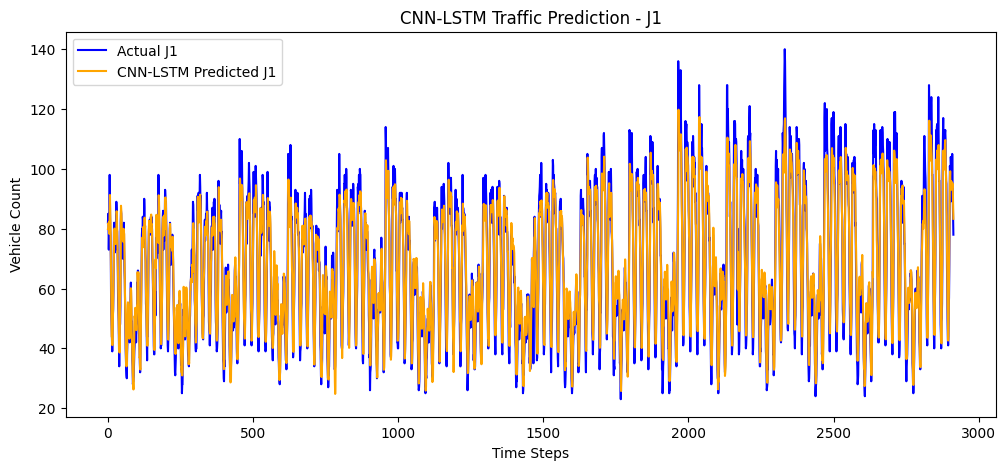

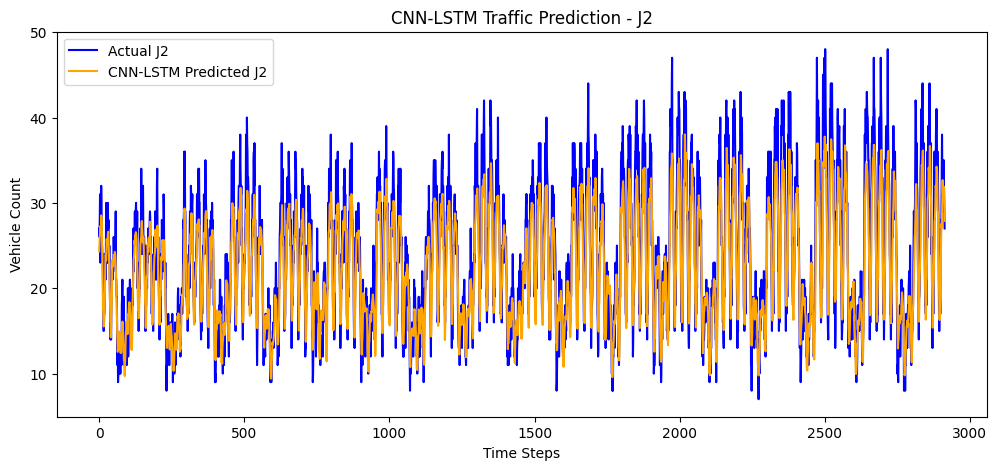

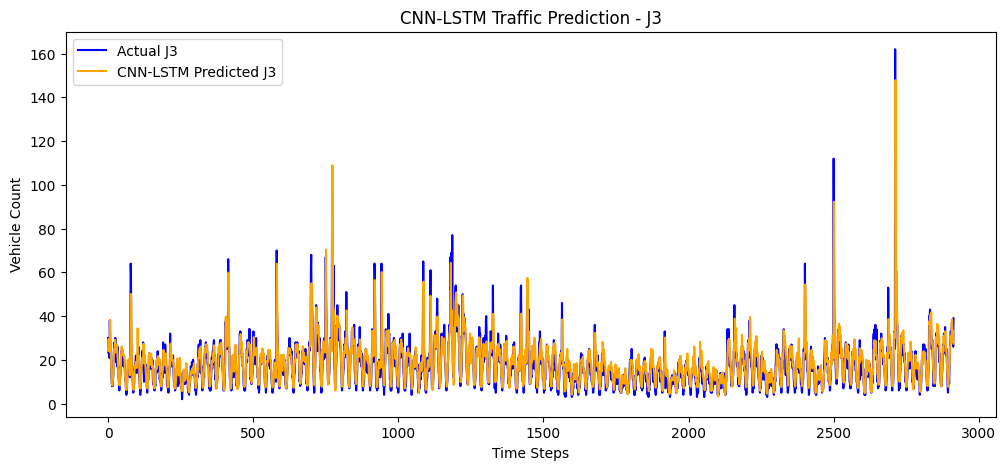

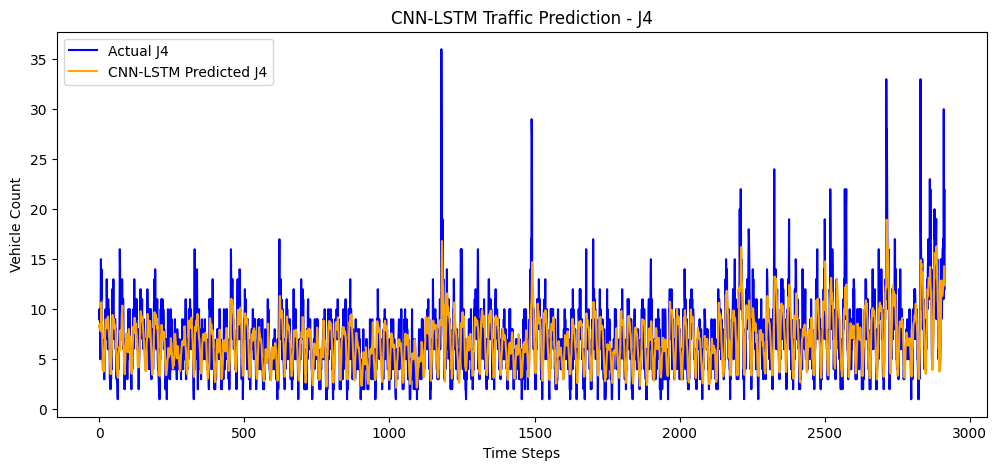

In [98]:
junction_names = ["J1", "J2", "J3", "J4"]

for j in range(4):
    plt.figure(figsize=(12,5))
    plt.plot(y_test_real[:, j], label=f"Actual {junction_names[j]}", color='blue')
    plt.plot(pred_real[:, j], label=f"CNN-LSTM Predicted {junction_names[j]}", color='orange')
    plt.title(f"CNN-LSTM Traffic Prediction - {junction_names[j]}")
    plt.xlabel("Time Steps")
    plt.ylabel("Vehicle Count")
    plt.legend()
    plt.show()



In [97]:
for j in range(4):
    mae = mean_absolute_error(y_test_real[:,j], pred_real[:,j])
    rmse = np.sqrt(mean_squared_error(y_test_real[:,j], pred_real[:,j]))
    print(f"Junction {j+1} → MAE: {mae:.2f}, RMSE: {rmse:.2f}")


Junction 1 → MAE: 5.04, RMSE: 6.60
Junction 2 → MAE: 2.74, RMSE: 3.57
Junction 3 → MAE: 3.48, RMSE: 6.06
Junction 4 → MAE: 1.80, RMSE: 2.46


In [ ]:
# gru + cnn

In [99]:
from tensorflow.keras.layers import GRU

model_cnn_gru = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu',
           input_shape=(X_train_s.shape[1], X_train_s.shape[2])),
    MaxPooling1D(pool_size=2),

    GRU(64, return_sequences=True),
    Dropout(0.2),
    GRU(32),

    Dense(4)  # predict all junctions
])

model_cnn_gru.compile(optimizer='adam', loss='mse')

model_cnn_gru.fit(X_train_s, y_train_s, epochs=20, batch_size=32)


Epoch 1/20


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


365/365 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0033
Epoch 2/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0018
Epoch 3/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0015 
Epoch 4/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0014
Epoch 5/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0014
Epoch 6/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0013
Epoch 7/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0013
Epoch 8/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0013
Epoch 9/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0013
Epoch 10/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0013
Epoch 11/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0012
Epoch 12/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0012
Epoch 13/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0012
Epoch 14/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0012
Epoch 15/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0012

In [100]:
pred_gru_spatial = model_cnn_gru.predict(X_test_s)

pred_gru_real = scaler_spatial.inverse_transform(pred_gru_spatial)
y_test_real = scaler_spatial.inverse_transform(y_test_s)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step   


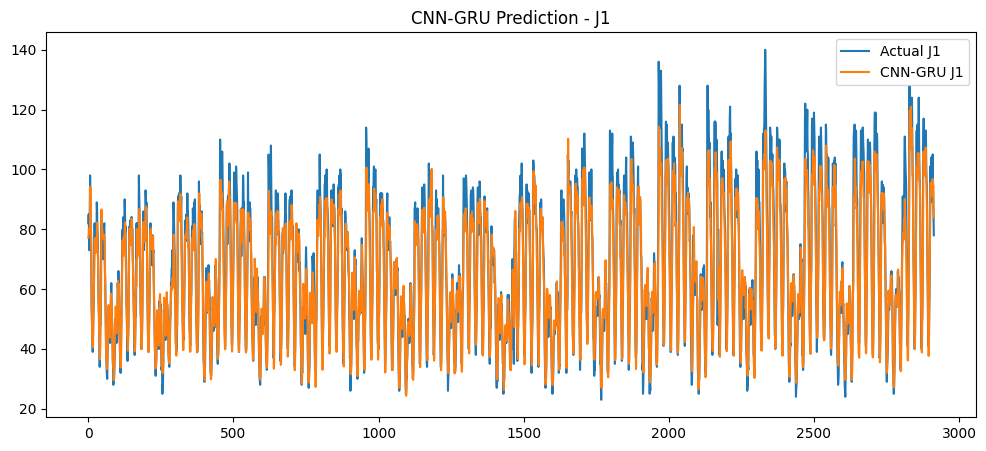

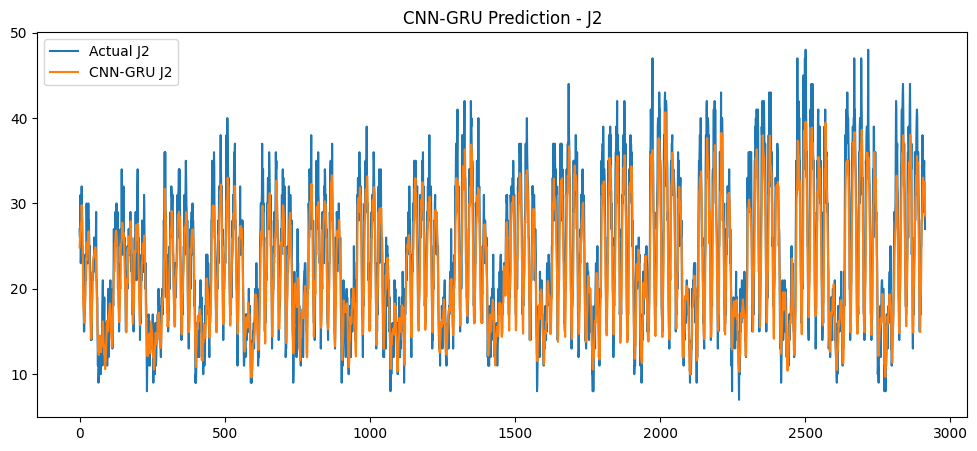

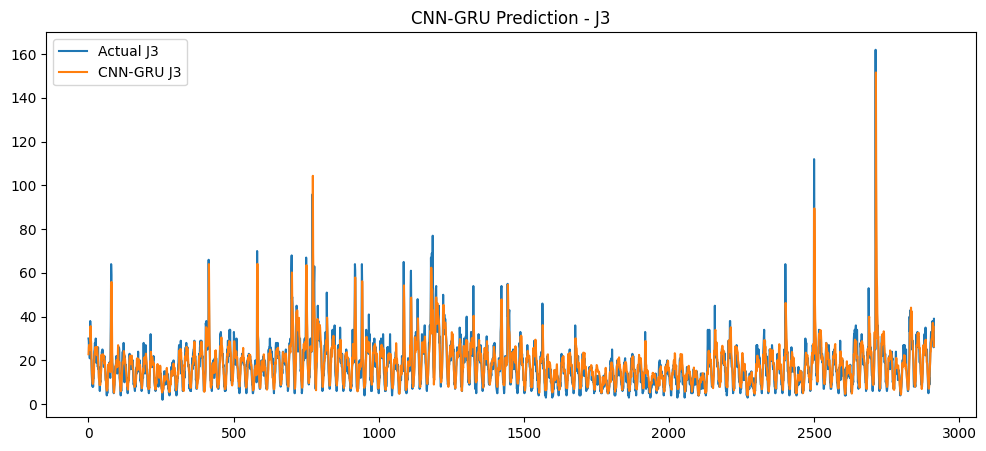

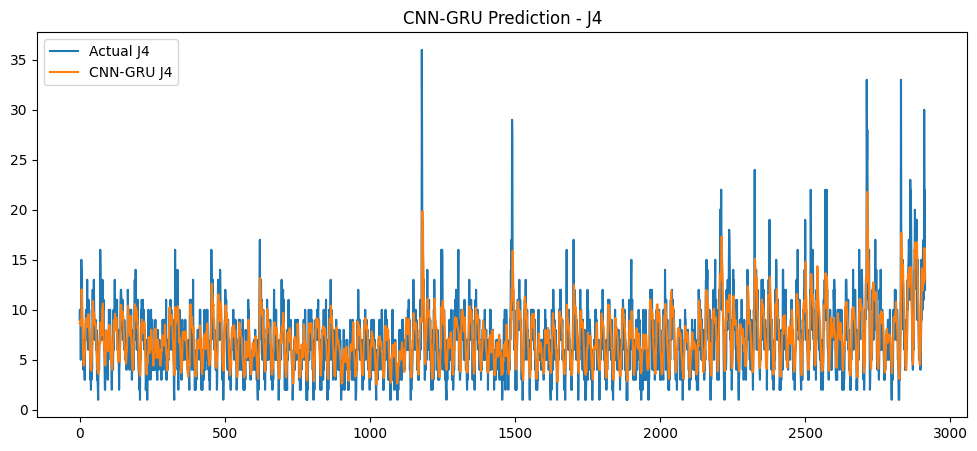

In [101]:
junction_names = ["J1","J2","J3","J4"]

for j in range(4):
    plt.figure(figsize=(12,5))
    plt.plot(y_test_real[:,j], label=f"Actual {junction_names[j]}")
    plt.plot(pred_gru_real[:,j], label=f"CNN-GRU {junction_names[j]}")
    plt.legend()
    plt.title(f"CNN-GRU Prediction - {junction_names[j]}")
    plt.show()


In [102]:
for j in range(4):
    mae = mean_absolute_error(y_test_real[:,j], pred_gru_real[:,j])
    rmse = np.sqrt(mean_squared_error(y_test_real[:,j], pred_gru_real[:,j]))
    print(f"J{j+1} → MAE: {mae:.2f}, RMSE: {rmse:.2f}")


J1 → MAE: 5.15, RMSE: 7.10
J2 → MAE: 2.62, RMSE: 3.37
J3 → MAE: 3.41, RMSE: 6.02
J4 → MAE: 1.79, RMSE: 2.42


In [ ]:
# cnn + transformer

In [103]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, MultiHeadAttention
from tensorflow.keras.layers import LayerNormalization, Dense, Dropout, Add, GlobalAveragePooling1D
from tensorflow.keras.models import Model

inputs = Input(shape=(X_train_s.shape[1], X_train_s.shape[2]))

# 🔹 CNN block (spatial patterns)
cnn = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
cnn = MaxPooling1D(pool_size=2)(cnn)

# 🔹 Transformer Attention block
attn = MultiHeadAttention(num_heads=4, key_dim=16)(cnn, cnn)
attn = Dropout(0.1)(attn)
attn = Add()([cnn, attn])
attn = LayerNormalization(epsilon=1e-6)(attn)

# 🔹 Feed-forward block
ff = Dense(64, activation='relu')(attn)
ff = Dense(attn.shape[-1])(ff)  # return to same dimension
ff = Dropout(0.1)(ff)
ff = Add()([attn, ff])
ff = LayerNormalization(epsilon=1e-6)(ff)

# 🔹 Pool + output
pooled = GlobalAveragePooling1D()(ff)
outputs = Dense(4)(pooled)  # predict all junctions

model_cnn_tr = Model(inputs, outputs)
model_cnn_tr.compile(optimizer='adam', loss='mse')

model_cnn_tr.fit(X_train_s, y_train_s, epochs=20, batch_size=32)


Epoch 1/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - loss: 0.0165
Epoch 2/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0074
Epoch 3/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0060 
Epoch 4/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0055
Epoch 5/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0049
Epoch 6/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0048
Epoch 7/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0044
Epoch 8/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0043
Epoch 9/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0042 
Epoch 10/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0041 
Epoch 11/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0040 
Epoch 12/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0041
Epoch 13/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0039 
Epoch 14/20
365/365 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0039 
Epoch 15/20
365/365 ━━━━━━━━━━━━━━━━

In [104]:
pred_tr_spatial = model_cnn_tr.predict(X_test_s)

pred_tr_real = scaler_spatial.inverse_transform(pred_tr_spatial)
y_test_real = scaler_spatial.inverse_transform(y_test_s)


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step   


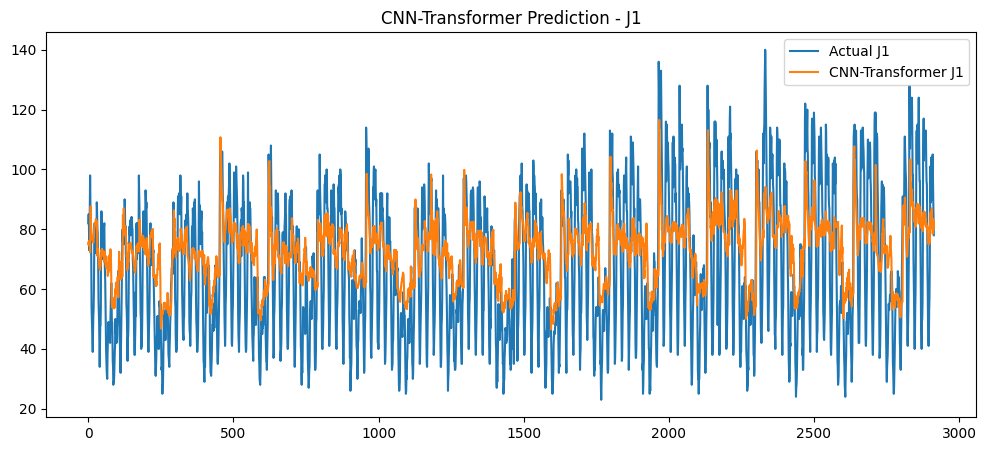

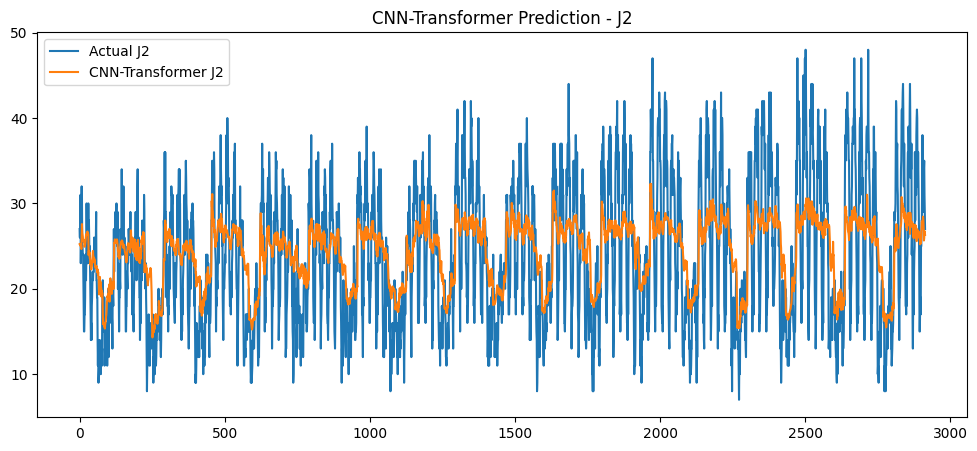

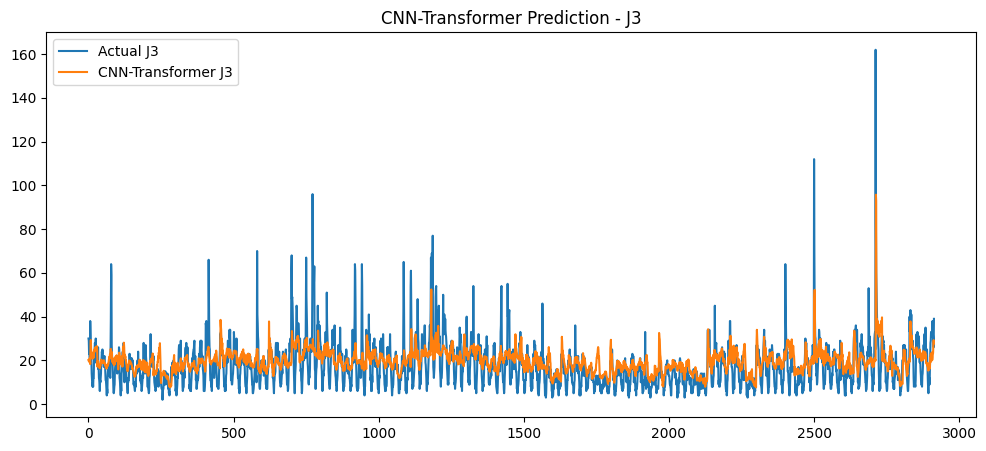

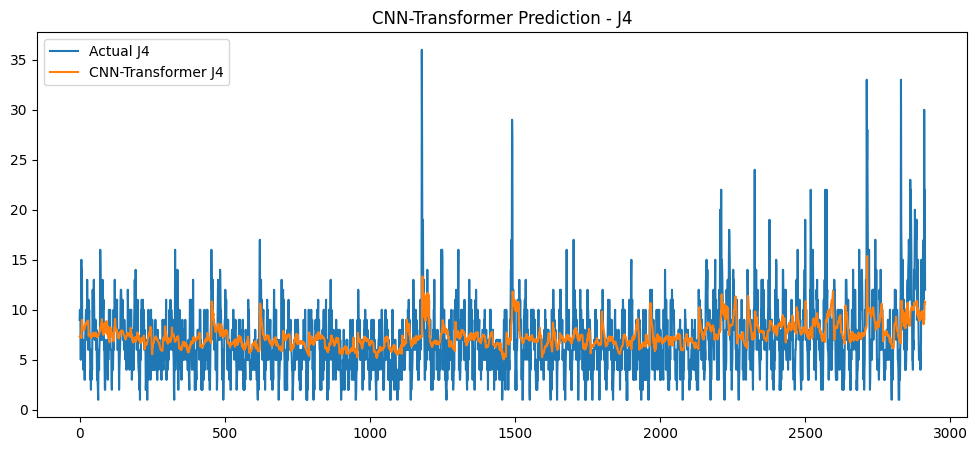

In [105]:
junction_names = ["J1","J2","J3","J4"]

for j in range(4):
    plt.figure(figsize=(12,5))
    plt.plot(y_test_real[:,j], label=f"Actual {junction_names[j]}")
    plt.plot(pred_tr_real[:,j], label=f"CNN-Transformer {junction_names[j]}")
    plt.legend()
    plt.title(f"CNN-Transformer Prediction - {junction_names[j]}")
    plt.show()


In [106]:
for j in range(4):
    mae = mean_absolute_error(y_test_real[:,j], pred_tr_real[:,j])
    rmse = np.sqrt(mean_squared_error(y_test_real[:,j], pred_tr_real[:,j]))
    print(f"J{j+1} → MAE: {mae:.2f}, RMSE: {rmse:.2f}")


J1 → MAE: 15.91, RMSE: 19.19
J2 → MAE: 5.27, RMSE: 6.45
J3 → MAE: 6.34, RMSE: 9.01
J4 → MAE: 2.40, RMSE: 3.20
